In [1]:
import foolbox as fb
import Pipelines.helperfiles.helpers as helpers
import Pipelines.helperfiles.experiment as experiment

In [3]:
ds_train, ds_val, ds_test, attack_images, attack_labels = helpers.load_data('imagenette')
model = helpers.initialize_base_model('ResNet8',ds_train,'',1, lr=1e-3)

67/67 [==============================] - 6s 85ms/step - loss: 2.8372 - accuracy: 0.2454


Epoch 1/150
67/67 [==============================] - 10s 157ms/step - loss: 1.9064 - accuracy: 0.3518 - val_loss: 2.7985 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 2/150
67/67 [==============================] - 6s 91ms/step - loss: 1.7114 - accuracy: 0.4233 - val_loss: 2.7540 - val_accuracy: 0.1595 - lr: 0.0010
Epoch 3/150
67/67 [==============================] - 6s 91ms/step - loss: 1.5231 - accuracy: 0.4899 - val_loss: 2.4703 - val_accuracy: 0.1850 - lr: 0.0010
Epoch 4/150
67/67 [==============================] - 6s 92ms/step - loss: 1.3847 - accuracy: 0.5407 - val_loss: 2.9812 - val_accuracy: 0.1834 - lr: 0.0010
Epoch 5/150
67/67 [==============================] - 6s 91ms/step - loss: 1.2515 - accuracy: 0.5947 - val_loss: 2.5938 - val_accuracy: 0.2448 - lr: 0.0010
Epoch 6/150
67/67 [==============================] - 6s 91ms/step - loss: 1.1925 - accuracy: 0.6128 - val_loss: 1.9832 - val_accuracy: 0.3506 - lr: 0.0010
Epoch 7/150
67/67 [==============================] - 6s 91ms/step - 

67/67 [==============================] - 6s 92ms/step - loss: 0.3270 - accuracy: 0.8905 - val_loss: 1.3858 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 54/150
67/67 [==============================] - 6s 91ms/step - loss: 0.3114 - accuracy: 0.8981 - val_loss: 0.8386 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 55/150
67/67 [==============================] - 6s 92ms/step - loss: 0.3042 - accuracy: 0.8991 - val_loss: 0.7741 - val_accuracy: 0.8099 - lr: 0.0010
Epoch 56/150
67/67 [==============================] - 6s 92ms/step - loss: 0.1945 - accuracy: 0.9375 - val_loss: 0.7762 - val_accuracy: 0.8028 - lr: 3.0000e-04
Epoch 57/150
67/67 [==============================] - 6s 92ms/step - loss: 0.1626 - accuracy: 0.9467 - val_loss: 0.8144 - val_accuracy: 0.7786 - lr: 3.0000e-04
Epoch 58/150
67/67 [==============================] - 6s 92ms/step - loss: 0.1458 - accuracy: 0.9517 - val_loss: 0.6591 - val_accuracy: 0.8257 - lr: 3.0000e-04
Epoch 59/150
67/67 [==============================] - 6s 92ms/ste

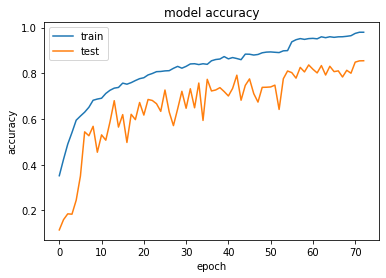

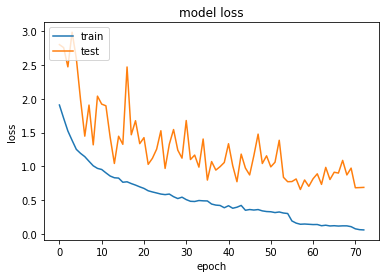

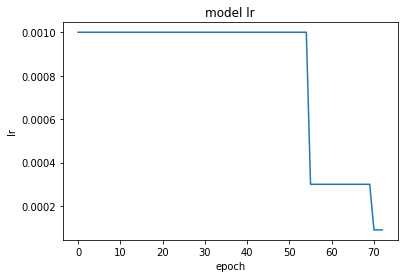

In [4]:
hist = helpers.train_model('ResNet8',ds_train, ds_test,model)
helpers.plot_hist(hist)

In [5]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
attack = fb.attacks.L2CarliniWagnerAttack(
    binary_search_steps = 9,
    steps= 5000,
    stepsize = .01,
    confidence = 0,
    initial_const = 1000000,
    abort_early = True,
)

adversarials, _, batch_success = attack(
        fmodel,
        attack_images[:32],
        attack_labels[:32],
        epsilons=None
    )

l2_adv = adversarials
l2_pert = (attack_images[:32]-l2_adv)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [6]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
init_attack = fb.attacks.DatasetAttack()
BATCHSIZE = 64
batches = [
    (attack_images[:BATCHSIZE], attack_labels[:BATCHSIZE]), 
    (attack_images[BATCHSIZE:2*BATCHSIZE], attack_labels[BATCHSIZE:2*BATCHSIZE]),
    (attack_images[2*BATCHSIZE:3*BATCHSIZE], attack_labels[2*BATCHSIZE:3*BATCHSIZE]), 
    (attack_images[3*BATCHSIZE:4*BATCHSIZE], attack_labels[3*BATCHSIZE:4*BATCHSIZE])
]

init_attack = fb.attacks.DatasetAttack()

init_attack.feed(fmodel, batches[0][0])   # feed 1st batch of inputs
init_attack.feed(fmodel, batches[1][0])   # feed 2nd batch of inputs
init_attack.feed(fmodel, batches[2][0])   # feed 1st batch of inputs
init_attack.feed(fmodel, batches[3][0])   # feed 2nd batch of inputs
attack = fb.attacks.L0BrendelBethgeAttack(binary_search_steps=30, steps=500,lr_num_decay=30, lr=1e7, init_attack=init_attack)

adversarials, _, batch_success = attack(
    fmodel,
    attack_images[:32],
    criterion=fb.criteria.Misclassification(attack_labels[:32]),
    epsilons=[None]
)
l0_adv = adversarials[0]

l0_pert = (attack_images[:32]-l0_adv)

In [69]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
attack = fb.attacks.LinfProjectedGradientDescentAttack()
res = [[],[],[],[],[],[]]
strengths = [0.125,0.25,0.5,1,2,4]


adversarials, _, success = attack(
    fmodel,
    attack_images[:32],
    attack_labels[:32],
    epsilons=255/255
)
l_inf_adv = adversarials

l_inf_pert = (attack_images[:32]-l_inf_adv)

In [8]:
advs = {
    'l0':{
        'original':attack_images[0],
        'adversarial':l0_adv,
        'perturbation':l0_pert,
        'adversarial_class':5,
    },
    'l2':{
        'original':attack_images[0],
        'adversarial':l2_adv,
        'perturbation':l2_pert,
        'adversarial_class':8
    },
    'linf':{
        'original':attack_images[0],
        'adversarial':l_inf_adv,
        'perturbation':l_inf_pert,
        'adversarial_class':8
    },
}

import pickle
filename = 'advs'
outfile = open(filename,'wb')
pickle.dump(advs,outfile)
outfile.close()

In [9]:
labels = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

In [52]:
import matplotlib.pyplot as plt
import numpy as np

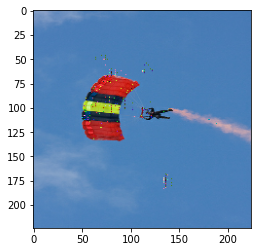

In [58]:
i=29
plt.imshow(l0_adv[i])

church


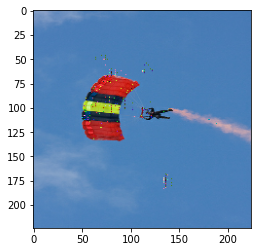

In [59]:
plt.imshow(l0_adv[i])
plt.imsave('l0_adv.png', (l0_adv[i]).numpy())
print(labels[np.argmax(model(l0_adv[i:i+1]))])

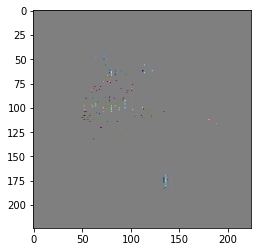

In [60]:
plt.imshow((l0_pert[i]+.5))
plt.imsave('l0_pert.png', np.clip((l0_pert[i]+.5).numpy(), 0,1))

church


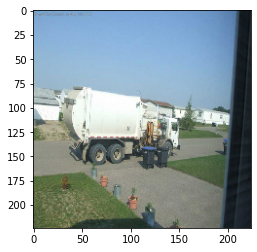

In [61]:
plt.imshow(l2_adv[17:18][0])
plt.imsave('l2_adv.png', np.clip((l2_adv[i]).numpy(), 0,1))
print(labels[np.argmax(model(l2_adv[i:i+1]))])

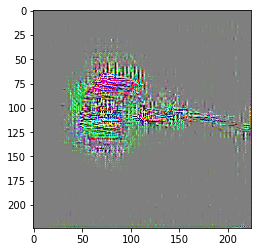

In [62]:
plt.imshow((l2_pert[i]*50+.5))
plt.imsave('l2_pert_50x.png', np.clip((l2_pert[i]*50+.5).numpy(), 0,1))

church


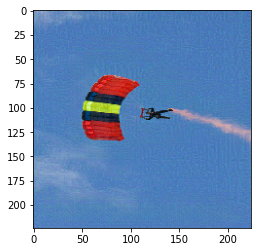

In [63]:
plt.imshow(l_inf_adv[i])
plt.imsave('l_inf_adv.png', np.clip((l_inf_adv[i]).numpy(), 0,1))
print(labels[np.argmax(model(l_inf_adv[i:i+1]))])

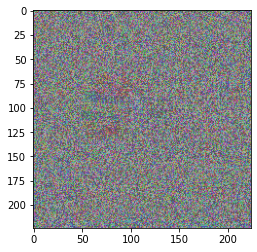

In [74]:
plt.imshow((np.sign(l_inf_pert[i])*5*8/255+.5))
plt.imsave('l_inf_pert_5x.png', np.clip((l_inf_pert[i]*5+.5).numpy(), 0,1))

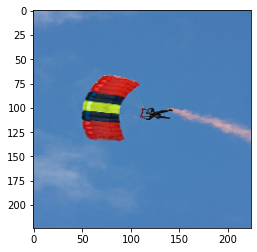

In [75]:
plt.imshow((attack_images[i]))
plt.imsave('original.png', np.clip((attack_images[i]).numpy(), 0,1))